In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
from utils.utils import metres_to_dist

In [2]:
G = ox.load_graphml("data/osmnx/graph.graphml")

# Match GPS data to map

In [3]:
public_gps_df = pd.read_csv("data/public/public_gps_traces_bbox.csv")

In [4]:
nearest_edges, dists = ox.nearest_edges(G, public_gps_df["longitude"], public_gps_df["latitude"], return_dist=True, interpolate=metres_to_dist(5))

In [5]:
#public_gps_df["nn"] = nearest_nodes
public_gps_df["dist"] = dists

In [6]:
d = 20

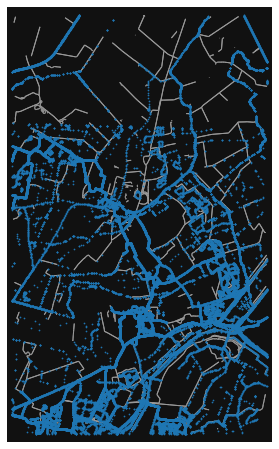

In [28]:
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)
ax.scatter(public_gps_df["longitude"], public_gps_df["latitude"], s=2, marker='.')
plt.show()

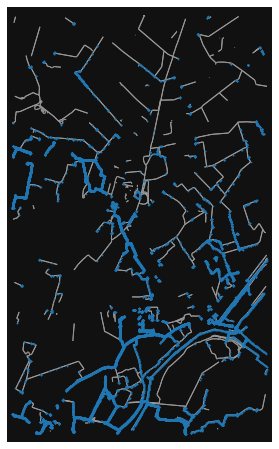

In [7]:
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)
ax.scatter(public_gps_df["longitude"].loc[public_gps_df["dist"] < d], public_gps_df["latitude"].loc[public_gps_df["dist"] < d], s=2, marker='.')
plt.show()

# Match ROW data to map

In [8]:
row_df = pd.read_csv("data/row/row_bbox.csv")

In [10]:
nearest_edges, dists = ox.nearest_edges(G, row_df["longitude"], row_df["latitude"], return_dist=True, interpolate=metres_to_dist(5))

In [11]:
#row_df["nn"] = nearest_nodes
row_df["dist"] = dists

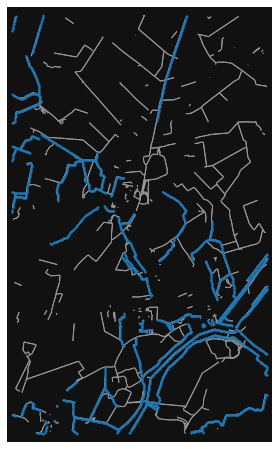

In [12]:
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)
ax.scatter(row_df["longitude"], row_df["latitude"], s=4, marker='.')
plt.show()

In [13]:
d=20

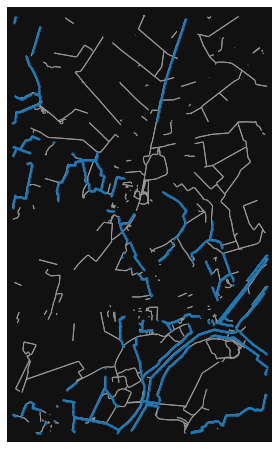

In [14]:
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)
ax.scatter(row_df["longitude"].loc[row_df["dist"] < d], row_df["latitude"].loc[row_df["dist"] < d], s=4, marker='.')
plt.show()

In [16]:
G

In [15]:
nearest_edges

[(4564841431, 5122821914, 0),
 (5122821915, 5122821914, 0),
 (5122821914, 5122821915, 0),
 (5122821915, 5122821914, 0),
 (5122821914, 5122821915, 0),
 (5122821914, 5122821915, 0),
 (5122821914, 5122821915, 0),
 (1179078965, 5122821915, 0),
 (5122821915, 1179078965, 0),
 (1179078965, 5122821915, 0),
 (1179078965, 5122821915, 0),
 (5122821915, 1179078965, 0),
 (1179078965, 5122821915, 0),
 (1179078965, 5122821915, 0),
 (5122821915, 1179078965, 0),
 (5122821915, 1179078965, 0),
 (5122821915, 1179078965, 0),
 (5122821915, 1179078965, 0),
 (5122821915, 1179078965, 0),
 (5122821915, 1179078965, 0),
 (5122821915, 1179078965, 0),
 (1179078959, 1179078965, 0),
 (1179078959, 1179078965, 0),
 (1179078965, 1179078959, 0),
 (1179078959, 1179078965, 0),
 (1179078959, 1179078965, 0),
 (1179078965, 1179078959, 0),
 (1179078959, 1179078965, 0),
 (1179078959, 1179078965, 0),
 (1179078965, 1179078959, 0),
 (1179078959, 1179078965, 0),
 (1179078965, 1179078959, 0),
 (1179078959, 1179078965, 0),
 (11790789

In [ ]:
ox.plot_graph_folium(G)

In [ ]:
nodes, edges = ox.graph_to_gdfs(G, fill_edge_geometry=True)

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
nodes.plot(ax=ax, facecolor='black')
edges.plot(ax=ax, facecolor='black')

In [54]:
dists = np.array(dists)

(array([12532.,  8973.,  6451.,  4529.,  3814.,  2958.,  2417.,  2060.,
         1832.,  1549.]),
 array([2.93381020e-02, 1.00247973e+01, 2.00202564e+01, 3.00157156e+01,
        4.00111748e+01, 5.00066339e+01, 6.00020931e+01, 6.99975522e+01,
        7.99930114e+01, 8.99884706e+01, 9.99839297e+01]),
 <BarContainer object of 10 artists>)

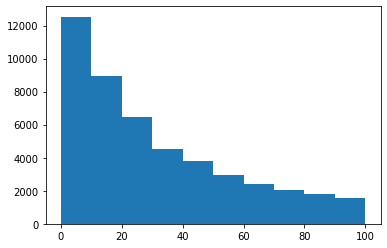

In [55]:
plt.hist(dists[dists<100])